# Final Project
## Bike sharing application using Bayesian network

- Check where the file locate

In [1]:
pwd

'/Users/hchae/Desktop'

### Importing the Dataset

In [2]:
import pandas as pd
dataset = pd.read_csv("london_merged.csv")

In [5]:
dataset.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


### Use pyBBN for creating Bayesian Networks 

In [3]:
# for creating Bayesian Belief Networks (BBN)
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

In [ ]:
pip install pybbn

### Function that calculates proabaility distribution

In [24]:
# This function helps to calculate probability distribution, which goes into BBN (note, can handle up to 2 parents)
def probs(data, child, parent1=None, parent2=None):
    if parent1==None:
        # Calculate probabilities
        prob=pd.crosstab(data[child], 'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
    elif parent1!=None:
            # Check if child node has 1 parent or 2 parents
            if parent2==None:
                # Caclucate probabilities
                prob=pd.crosstab(data[parent1],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
            else:    
                # Caclucate probabilities
                prob=pd.crosstab([data[parent1],data[parent2]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else: print("Error in Probability Frequency Calculations")
    return prob  

#### Further work needed - only few nodes are considered

In [25]:
#Create nodes by using our earlier function to automatically calculate probabilities
is_holiday = BbnNode(Variable(0, 'is_holiday', ['0.0', '1.0']), probs(dataset, child='cnt'))
#is_weedend = BbnNode(Variable(1, 'is_weedend'), probs(df, child='cnt'))

# child = node itself, parents = parents of its node
season = BbnNode(Variable(1, 'season',['0', '1','2','3']), probs(dataset, child='season'))
t1 = BbnNode(Variable(2, 't1',["1", "2"]), probs(dataset, child='t1', parent1='season'))
## wrong variable parameter
weather_code = BbnNode(Variable(3, 'weather_code',['1', '2','3','4','7','26']), probs(dataset,child='weather_code',parent1='t1'))         
number = BbnNode(Variable(4, 'cnt',["1", "2"]), probs(dataset, child='cnt',parent1='is_holiday', parent2='weather_code'))
## wrong variable parameter

# Create Network
bbn = Bbn() \
    .add_node(is_holiday) \
    .add_node(season) \
    .add_node(t1) \
    .add_node(weather_code) \
    .add_node(number) \
    .add_edge(Edge(is_holiday, number, EdgeType.DIRECTED)) \
    .add_edge(Edge(season, t1, EdgeType.DIRECTED)) \
    .add_edge(Edge(t1, weather_code, EdgeType.DIRECTED)) \
    .add_edge(Edge(weather_code, number, EdgeType.DIRECTED))

# Convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)

### Drawing graphs

In [4]:
# for drawing graphs
import networkx as nx 
# for drawing graphs
import matplotlib.pyplot as plt

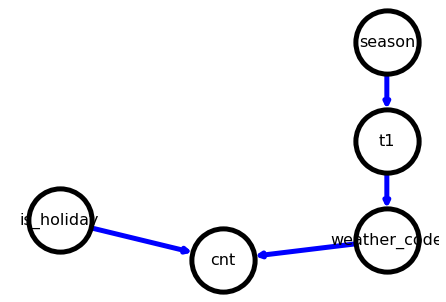

In [26]:
# Set node positions
pos = {0: (-1, 2), 1: (1, 20), 2: (1,10), 3: (1, 0), 4: (0, -2)}

# Set options for graph looks
options = {
    "font_size": 16,
    "node_size": 4000,
    "node_color": "white",
    "edgecolors": "black",
    "edge_color": "blue",
    "linewidths": 5,
    "width": 5,}
    
# Generate graph
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Update margins and print the graph
ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()

In [22]:
# Define a function for printing marginal probabilities
def print_probs():
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node)
        print("Values:")
        print(potential)
        print('----------------')
        
# Use the above function to print marginal probabilities
print_probs()

Node: 2|t1|1,2
Values:
2=1|0.10014
2=2|0.89986
----------------
Node: 1|season|0,1,2,3
Values:
1=0|0.00000
1=1|0.00000
1=2|0.36640
1=3|0.63360
----------------
Node: 3|weather_code|1,2,3,4,7,26
Values:
3=1|0.10014
3=2|0.65777
3=3|0.05025
3=4|0.09136
3=7|0.10049
3=26|0.00000
----------------
Node: 4|cnt|1,2
Values:
4=1|0.60541
4=2|0.39459
----------------
Node: 0|is_holiday|0.0,1.0
Values:
0=0.0|0.11876
0=1.0|0.88124
----------------


### Use pandas for data manipulation

In [1]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator,BayesianEstimator

### Add the Bayesian network

In [77]:
data = pd.DataFrame(data = dataset)
model = BayesianNetwork([("season","t1"),
                       ("season","hum"),
                       ("season","wind_speed"),
                       #("t1","weather_code"),
                       #("hum","weather_code"),
                       #("wind_speed","weather_code"),
                       #("weather_code","cnt"),
                       ("is_weekend","cnt"),
                       ("is_holiday","cnt")])

### Conditional Probability Table

- Probability distribution, P(season)
- Probability distribution, P(is_holiday)
- Probability distribution, P(is_weekend)


In [78]:
cpd_season = MaximumLikelihoodEstimator(model, data).estimate_cpd('season')
print('Probability Distribution - season')
print(cpd_season)

cpd_holiday = MaximumLikelihoodEstimator(model, dataset).estimate_cpd('is_holiday')
print('Probability Distribution - is_holiday')
print(cpd_holiday)

cpd_weekend = MaximumLikelihoodEstimator(model, dataset).estimate_cpd('is_weekend')
print('Probability Distribution - is_weekend')
print(cpd_weekend)

Probability Distribution - season
+-------------+----------+
| season(0.0) | 0.252326 |
+-------------+----------+
| season(1.0) | 0.251924 |
+-------------+----------+
| season(2.0) | 0.2471   |
+-------------+----------+
| season(3.0) | 0.248651 |
+-------------+----------+
Probability Distribution - is_holiday
+-----------------+-----------+
| is_holiday(0.0) | 0.977949  |
+-----------------+-----------+
| is_holiday(1.0) | 0.0220512 |
+-----------------+-----------+
Probability Distribution - is_weekend
+-----------------+----------+
| is_weekend(0.0) | 0.714597 |
+-----------------+----------+
| is_weekend(1.0) | 0.285403 |
+-----------------+----------+


- Joint Probability distribution, P(t1 | season)
- Joint Probability distribution, P(hum | season)
- Joint Probability distribution, P(wind_speed | season)

In [79]:
cpd_t1 = MaximumLikelihoodEstimator(model, dataset).estimate_cpd('t1')
print(cpd_t1)

+------------------------+-----+------------------------+
| season                 | ... | season(3.0)            |
+------------------------+-----+------------------------+
| t1(-1.5)               | ... | 0.00023094688221709007 |
+------------------------+-----+------------------------+
| t1(-1.0)               | ... | 0.005080831408775982   |
+------------------------+-----+------------------------+
| t1(-0.5)               | ... | 0.003464203233256351   |
+------------------------+-----+------------------------+
| t1(0.0)                | ... | 0.0062355658198614316  |
+------------------------+-----+------------------------+
| t1(0.5)                | ... | 0.005311778290993071   |
+------------------------+-----+------------------------+
| t1(1.0)                | ... | 0.020554272517321018   |
+------------------------+-----+------------------------+
| t1(1.5)                | ... | 0.007621247113163972   |
+------------------------+-----+------------------------+
| t1(2.0)     

In [80]:
cpd_hum = MaximumLikelihoodEstimator(model, dataset).estimate_cpd('hum')
print(cpd_hum)

+------------+-----+------------------------+
| season     | ... | season(3.0)            |
+------------+-----+------------------------+
| hum(20.5)  | ... | 0.0                    |
+------------+-----+------------------------+
| hum(23.0)  | ... | 0.0                    |
+------------+-----+------------------------+
| hum(23.5)  | ... | 0.0                    |
+------------+-----+------------------------+
| hum(24.0)  | ... | 0.0                    |
+------------+-----+------------------------+
| hum(25.0)  | ... | 0.0                    |
+------------+-----+------------------------+
| hum(25.5)  | ... | 0.0                    |
+------------+-----+------------------------+
| hum(26.0)  | ... | 0.0                    |
+------------+-----+------------------------+
| hum(26.5)  | ... | 0.0                    |
+------------+-----+------------------------+
| hum(27.0)  | ... | 0.0                    |
+------------+-----+------------------------+
| hum(28.0)  | ... | 0.0          

In [81]:
cpd_windSpeed = MaximumLikelihoodEstimator(model, dataset).estimate_cpd('wind_speed')
print(cpd_windSpeed)

+--------------------------------+-----+------------------------+
| season                         | ... | season(3.0)            |
+--------------------------------+-----+------------------------+
| wind_speed(0.0)                | ... | 0.004618937644341801   |
+--------------------------------+-----+------------------------+
| wind_speed(1.0)                | ... | 0.00023094688221709007 |
+--------------------------------+-----+------------------------+
| wind_speed(2.0)                | ... | 0.011547344110854504   |
+--------------------------------+-----+------------------------+
| wind_speed(2.6666666666666665) | ... | 0.0                    |
+--------------------------------+-----+------------------------+
| wind_speed(3.0)                | ... | 0.008083140877598153   |
+--------------------------------+-----+------------------------+
| wind_speed(3.5)                | ... | 0.0009237875288683603  |
+--------------------------------+-----+------------------------+
| wind_spe

- Joint Probability distribution, P(weather_code | t1, hum, wind_speed)

In [16]:
#cpd_weather = MaximumLikelihoodEstimator(model, dataset).estimate_cpd('weather_code')
#print(cpd_weather)

KeyboardInterrupt: 

- Joint Probability distribution, P(cnt | is_holiday, is_weekend, weather_code)

In [82]:
cpd_cnt = MaximumLikelihoodEstimator(model, dataset).estimate_cpd('cnt')
print(cpd_cnt)

+------------+-----+-----------------------+
| is_holiday | ... | is_holiday(1.0)       |
+------------+-----+-----------------------+
| is_weekend | ... | is_weekend(1.0)       |
+------------+-----+-----------------------+
| cnt(0)     | ... | 0.0002644802962179318 |
+------------+-----+-----------------------+
| cnt(9)     | ... | 0.0002644802962179318 |
+------------+-----+-----------------------+
| cnt(10)    | ... | 0.0002644802962179318 |
+------------+-----+-----------------------+
| cnt(11)    | ... | 0.0002644802962179318 |
+------------+-----+-----------------------+
| cnt(12)    | ... | 0.0002644802962179318 |
+------------+-----+-----------------------+
| cnt(13)    | ... | 0.0002644802962179318 |
+------------+-----+-----------------------+
| cnt(14)    | ... | 0.0002644802962179318 |
+------------+-----+-----------------------+
| cnt(15)    | ... | 0.0002644802962179318 |
+------------+-----+-----------------------+
| cnt(16)    | ... | 0.0002644802962179318 |
+---------

In [95]:
# Add CPDs to the network structure

## add the weather code later on ##

#model.add_cpds(cpd_season, cpd_holiday, cpd_weekend, cpd_t1, cpd_hum, cpd_windSpeed, cpd_cnt)
model.add_cpds(cpd_season,cpd_holiday,cpd_weekend, cpd_t1,cpd_hum, cpd_windSpeed,cpd_cnt)

In [96]:
# Check if the model is valid
model.check_model()

True

In [102]:
pip install decorator==4.3

  Attempting uninstall: decorator
    Found existing installation: decorator 5.0.6
    Uninstalling decorator-5.0.6:
      Successfully uninstalled decorator-5.0.6
Note: you may need to restart the kernel to use updated packages.


NetworkXError: random_state_index is incorrect

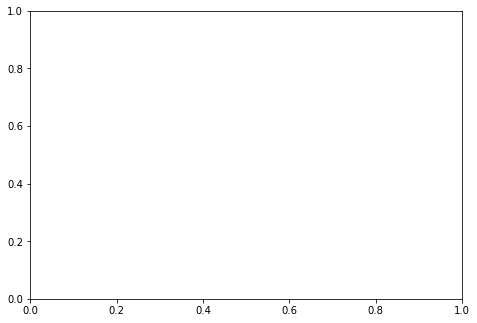

In [104]:
# Set options for graph looks
options = {
    "font_size": 16,
    "node_size": 4000,
    "node_color": "white",
    "edgecolors": "black",
    "edge_color": "blue",
    "linewidths": 5,
    "width": 5,}
    
# Generate graph
nx.draw(model, with_labels=True)

# Update margins and print the graph
#ax = plt.gca()
#ax.margins(0.10)
plt.axis("off")
plt.show()

In [58]:
 from pgmpy.inference import VariableElimination
 infer = VariableElimination(model)
 g_dist = infer.query(['cnt'])
 print(g_dist) 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

+-----------+------------+
| cnt       |   phi(cnt) |
+===========+============+
| cnt(0)    |     0.0001 |
+-----------+------------+
| cnt(9)    |     0.0001 |
+-----------+------------+
| cnt(10)   |     0.0001 |
+-----------+------------+
| cnt(11)   |     0.0001 |
+-----------+------------+
| cnt(12)   |     0.0002 |
+-----------+------------+
| cnt(13)   |     0.0001 |
+-----------+------------+
| cnt(14)   |     0.0003 |
+-----------+------------+
| cnt(15)   |     0.0002 |
+-----------+------------+
| cnt(16)   |     0.0003 |
+-----------+------------+
| cnt(17)   |     0.0003 |
+-----------+------------+
| cnt(18)   |     0.0003 |
+-----------+------------+
| cnt(19)   |     0.0004 |
+-----------+------------+
| cnt(20)   |     0.0006 |
+-----------+------------+
| cnt(21)   |     0.0006 |
+-----------+------------+
| cnt(22)   |     0.0006 |
+-----------+------------+
| cnt(23)   |     0.0006 |
+-----------+------------+
| cnt(24)   |     0.0009 |
+-----------+------------+
|

In [99]:
t1 = infer.query(['t1'])
print(t1) 

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

+------------------------+-----------+
| t1                     |   phi(t1) |
+========================+===========+
| t1(-1.5)               |    0.0001 |
+------------------------+-----------+
| t1(-1.0)               |    0.0013 |
+------------------------+-----------+
| t1(-0.5)               |    0.0009 |
+------------------------+-----------+
| t1(0.0)                |    0.0020 |
+------------------------+-----------+
| t1(0.5)                |    0.0014 |
+------------------------+-----------+
| t1(1.0)                |    0.0064 |
+------------------------+-----------+
| t1(1.5)                |    0.0022 |
+------------------------+-----------+
| t1(2.0)                |    0.0097 |
+------------------------+-----------+
| t1(2.5)                |    0.0045 |
+------------------------+-----------+
| t1(3.0)                |    0.0143 |
+------------------------+-----------+
| t1(3.5)                |    0.0054 |
+------------------------+-----------+
| t1(4.0)                

In [ ]:
t1 = infer.query([''])
print(t1) 